# Comprehensive DCA Fundamentals

This notebook provides a complete introduction to decline curve analysis using the `decline_curve` library.

## Learning Objectives

By the end of this notebook, you will be able to:
- Load and prepare production data
- Fit Arps decline models (exponential, harmonic, hyperbolic)
- Generate and evaluate forecasts
- Calculate reserves (EUR)
- Visualize results professionally
- Compare different decline models

## Table of Contents
1. [Setup and Imports](#setup)
2. [Data Loading and Preparation](#data)
3. [Arps Decline Models](#arps)
4. [Forecasting](#forecasting)
5. [Reserve Estimation](#reserves)
6. [Model Evaluation](#evaluation)
7. [Visualization](#visualization)

## 1. Setup and Imports {#setup}

First, we'll import all necessary libraries and configure the environment.

In [2]:
# Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Decline curve analysis imports
from decline_curve import dca
from decline_curve.models import ArpsParams, fit_arps, predict_arps
from decline_curve.reserves import forecast_and_reserves
from decline_curve.evaluate import evaluate_forecast
from decline_curve.plot import plot_forecast, minimal_style

# Configure plotting
minimal_style()
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ All imports successful!
✓ Pandas version: 2.3.3
✓ NumPy version: 1.26.4


## 2. Data Loading and Preparation {#data}

We'll create synthetic production data that mimics real well behavior. In practice, you would load data from CSV files, databases, or regulatory sources.

In [3]:
# Generate realistic production data
np.random.seed(42)  # For reproducibility

# Create monthly dates
dates = pd.date_range('2020-01-01', periods=36, freq='MS')

# Simulate hyperbolic decline (most common in shale)
qi = 1200  # Initial production rate (bbl/month)
di = 0.15  # Initial decline rate (1/month)
b = 0.4    # Hyperbolic exponent

t = np.arange(len(dates))
production = qi / (1 + b * di * t) ** (1 / b)

# Add realistic noise and operational variations
noise = np.random.normal(0, production * 0.08, size=len(dates))
operational_effects = np.random.choice([0.9, 1.0, 1.1], len(dates), p=[0.2, 0.6, 0.2])
production = np.maximum(production * operational_effects + noise, 0)

# Create pandas Series with DatetimeIndex (required format)
well_data = pd.Series(production, index=dates, name='oil_production_bbl')

# Display summary statistics
print("=" * 70)
print("PRODUCTION DATA SUMMARY")
print("=" * 70)
print(f"Period: {well_data.index[0].strftime('%Y-%m')} to {well_data.index[-1].strftime('%Y-%m')}")
print(f"Data points: {len(well_data)}")
print(f"Peak production: {well_data.max():.0f} bbl/month")
print(f"Current production: {well_data.iloc[-1]:.0f} bbl/month")
print(f"Cumulative production: {well_data.sum():,.0f} bbl")
print(f"Average production: {well_data.mean():.0f} bbl/month")
print("=" * 70)

# Display first and last few rows
print("\nFirst 5 months:")
print(well_data.head())
print("\nLast 5 months:")
print(well_data.tail())

PRODUCTION DATA SUMMARY
Period: 2020-01 to 2022-12
Data points: 36
Peak production: 1248 bbl/month
Current production: 64 bbl/month
Cumulative production: 11,656 bbl
Average production: 324 bbl/month

First 5 months:
2020-01-01    1247.684559
2020-02-01    1025.855104
2020-03-01     950.770249
2020-04-01     810.699942
2020-05-01     757.809901
Freq: MS, Name: oil_production_bbl, dtype: float64

Last 5 months:
2022-08-01    90.929115
2022-09-01    82.272543
2022-10-01    63.826687
2022-11-01    86.820579
2022-12-01    63.994642
Freq: MS, Name: oil_production_bbl, dtype: float64


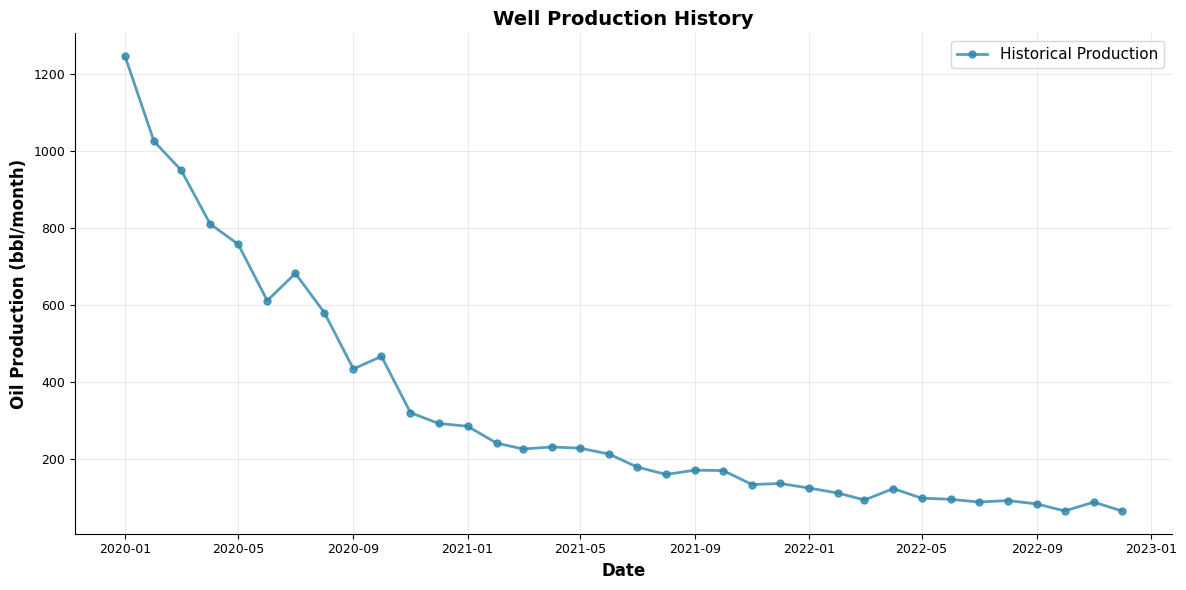

In [4]:
# Visualize production history
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(well_data.index, well_data.values, 'o-', linewidth=2, markersize=5, 
        label='Historical Production', color='#2E86AB', alpha=0.8)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Oil Production (bbl/month)', fontsize=12, fontweight='bold')
ax.set_title('Well Production History', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Arps Decline Models {#arps}

The Arps decline models are the foundation of decline curve analysis. We'll fit three types:

1. **Exponential Decline** (b=0): Constant percentage decline rate
2. **Hyperbolic Decline** (0<b<1): Decreasing decline rate over time
3. **Harmonic Decline** (b=1): Special case of hyperbolic

### 3.1 Fit Exponential Decline

In [5]:
# Fit exponential decline model
exp_params = fit_arps(np.arange(len(well_data)), well_data.values, kind='exponential')

print("=" * 70)
print("EXPONENTIAL DECLINE MODEL PARAMETERS")
print("=" * 70)
print(f"Initial rate (qi): {exp_params.qi:.2f} bbl/month")
print(f"Decline rate (di): {exp_params.di:.4f} 1/month")
print(f"Decline exponent (b): {exp_params.b:.4f}")
print("=" * 70)

# Generate predictions for historical period
t_hist = np.arange(len(well_data))
exp_predicted = predict_arps(t_hist, exp_params)

# Calculate fit quality
from decline_curve.evaluate import evaluate_forecast
exp_metrics = evaluate_forecast(well_data, pd.Series(exp_predicted, index=well_data.index))

print("\nModel Fit Quality:")
print(f"  RMSE: {exp_metrics['rmse']:.2f} bbl/month")
print(f"  MAE: {exp_metrics['mae']:.2f} bbl/month")
print(f"  R²: {exp_metrics['r2']:.4f}")

EXPONENTIAL DECLINE MODEL PARAMETERS
Initial rate (qi): 1164.14 bbl/month
Decline rate (di): 0.1068 1/month
Decline exponent (b): 0.0000

Model Fit Quality:
  RMSE: 42.77 bbl/month
  MAE: 37.29 bbl/month
  R²: 0.9803


### 3.2 Fit Hyperbolic Decline

In [6]:
# Fit hyperbolic decline model
hyp_params = fit_arps(np.arange(len(well_data)), well_data.values, kind='hyperbolic')

print("=" * 70)
print("HYPERBOLIC DECLINE MODEL PARAMETERS")
print("=" * 70)
print(f"Initial rate (qi): {hyp_params.qi:.2f} bbl/month")
print(f"Decline rate (di): {hyp_params.di:.4f} 1/month")
print(f"Decline exponent (b): {hyp_params.b:.4f}")
print("=" * 70)

# Generate predictions
hyp_predicted = predict_arps(t_hist, hyp_params)
hyp_metrics = evaluate_forecast(well_data, pd.Series(hyp_predicted, index=well_data.index))

print("\nModel Fit Quality:")
print(f"  RMSE: {hyp_metrics['rmse']:.2f} bbl/month")
print(f"  MAE: {hyp_metrics['mae']:.2f} bbl/month")
print(f"  R²: {hyp_metrics['r2']:.4f}")

HYPERBOLIC DECLINE MODEL PARAMETERS
Initial rate (qi): 1233.22 bbl/month
Decline rate (di): 0.1422 1/month
Decline exponent (b): 0.3055

Model Fit Quality:
  RMSE: 31.69 bbl/month
  MAE: 23.06 bbl/month
  R²: 0.9892


### 3.3 Compare All Models

In [7]:
# Fit harmonic decline
harm_params = fit_arps(np.arange(len(well_data)), well_data.values, kind='harmonic')
harm_predicted = predict_arps(t_hist, harm_params)
harm_metrics = evaluate_forecast(well_data, pd.Series(harm_predicted, index=well_data.index))

# Create comparison DataFrame
comparison = pd.DataFrame({
    'Exponential': exp_metrics,
    'Hyperbolic': hyp_metrics,
    'Harmonic': harm_metrics
}).T

print("=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(comparison.round(4))
print("\nBest model (lowest RMSE):", comparison['rmse'].idxmin())
print("Best model (highest R²):", comparison['r2'].idxmax())

MODEL COMPARISON
                rmse      mae    smape     mape      r2
Exponential  42.7697  37.2921  26.9828  22.2634  0.9803
Hyperbolic   31.6933  23.0598   9.1771   9.0077  0.9892
Harmonic     65.4468  58.1494  27.1386  33.5498  0.9538

Best model (lowest RMSE): Hyperbolic
Best model (highest R²): Hyperbolic


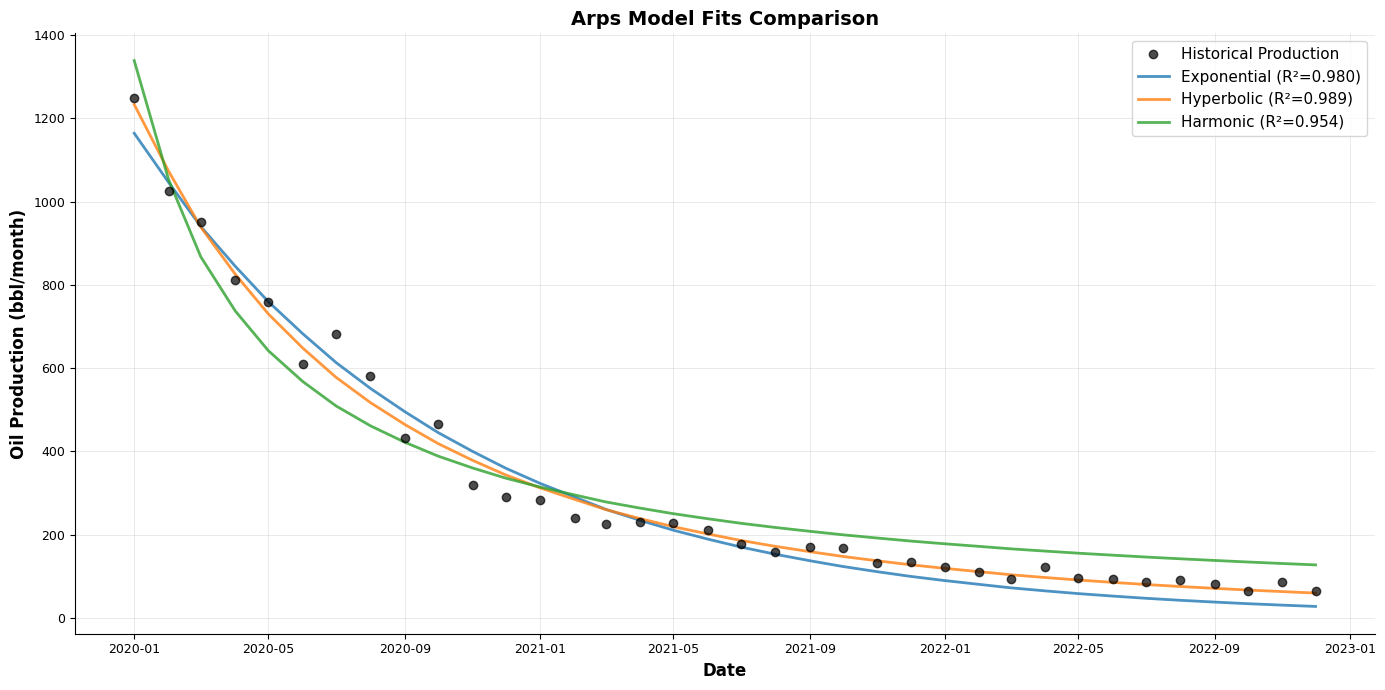

In [8]:
# Visualize all model fits
fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
ax.plot(well_data.index, well_data.values, 'o', markersize=6, 
        label='Historical Production', color='black', alpha=0.7, zorder=5)

# Model fits
ax.plot(well_data.index, exp_predicted, '-', linewidth=2, 
        label=f"Exponential (R²={exp_metrics['r2']:.3f})", alpha=0.8)
ax.plot(well_data.index, hyp_predicted, '-', linewidth=2, 
        label=f"Hyperbolic (R²={hyp_metrics['r2']:.3f})", alpha=0.8)
ax.plot(well_data.index, harm_predicted, '-', linewidth=2, 
        label=f"Harmonic (R²={harm_metrics['r2']:.3f})", alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Oil Production (bbl/month)', fontsize=12, fontweight='bold')
ax.set_title('Arps Model Fits Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Forecasting {#forecasting}

Now we'll generate forecasts using the best-fitting model. The `dca.forecast()` function provides a convenient high-level API.

In [9]:
# Generate forecast using the high-level API
horizon = 24  # Forecast 24 months into the future
forecast = dca.forecast(well_data, model='arps', kind='hyperbolic', horizon=horizon)

print("=" * 70)
print("FORECAST SUMMARY")
print("=" * 70)
print(f"Historical data: {len(well_data)} months")
print(f"Forecast horizon: {horizon} months")
print(f"Total forecast length: {len(forecast)} months")
print(f"\nFirst forecast value: {forecast.iloc[len(well_data)]:.1f} bbl/month")
print(f"Last forecast value: {forecast.iloc[-1]:.1f} bbl/month")
print(f"Forecast decline: {((forecast.iloc[len(well_data)] - forecast.iloc[-1]) / forecast.iloc[len(well_data)] * 100):.1f}%")
print("=" * 70)

FORECAST SUMMARY
Historical data: 36 months
Forecast horizon: 24 months
Total forecast length: 60 months

First forecast value: 56.6 bbl/month
Last forecast value: 19.3 bbl/month
Forecast decline: 65.9%


In [ ]:
# Visualize forecast
plot_forecast(well_data, forecast, show_metrics=True, title='Production Forecast - Hyperbolic Decline')

## 5. Reserve Estimation {#reserves}

Estimated Ultimate Recovery (EUR) is a key metric for reserve estimation. We'll calculate EUR using the reserves module.

In [10]:
# Calculate reserves using the fitted parameters
from decline_curve.models import ArpsParams

# Create ArpsParams object
arps_params = ArpsParams(
    qi=hyp_params.qi,
    di=hyp_params.di,
    b=hyp_params.b
)

# Calculate reserves
reserves_result = forecast_and_reserves(arps_params, t_max=600, econ_limit=10.0)

print("=" * 70)
print("RESERVE ESTIMATION")
print("=" * 70)
print(f"Estimated Ultimate Recovery (EUR): {reserves_result['eur']:,.0f} bbl")
print(f"Economic limit: {reserves_result.get('econ_limit', 10.0):.1f} bbl/month")
print(f"Time to economic limit: {reserves_result.get('t_econ', 0):.0f} months")
print(f"Cumulative production to date: {well_data.sum():,.0f} bbl")
print(f"Remaining reserves: {reserves_result['eur'] - well_data.sum():,.0f} bbl")
print("=" * 70)

RESERVE ESTIMATION
Estimated Ultimate Recovery (EUR): 12,061 bbl
Economic limit: 10.0 bbl/month
Time to economic limit: 0 months
Cumulative production to date: 11,656 bbl
Remaining reserves: 405 bbl


## 6. Model Evaluation {#evaluation}

We'll use cross-validation to evaluate model performance more rigorously.

In [11]:
# Split data into training and validation sets
split_point = int(len(well_data) * 0.75)  # Use 75% for training
train_data = well_data.iloc[:split_point]
test_data = well_data.iloc[split_point:]

print(f"Training period: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
print(f"Test period: {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")

# Fit model on training data
train_params = fit_arps(np.arange(len(train_data)), train_data.values, kind='hyperbolic')

# Generate forecast for test period
t_test = np.arange(len(test_data))
test_forecast = predict_arps(t_test, train_params)
test_forecast_series = pd.Series(test_forecast, index=test_data.index)

# Evaluate on test set
test_metrics = evaluate_forecast(test_data, test_forecast_series)

print("\n" + "=" * 70)
print("OUT-OF-SAMPLE VALIDATION")
print("=" * 70)
print(f"RMSE: {test_metrics['rmse']:.2f} bbl/month")
print(f"MAE: {test_metrics['mae']:.2f} bbl/month")
print(f"SMAPE: {test_metrics['smape']:.2f}%")
print(f"R²: {test_metrics['r2']:.4f}")
print("=" * 70)

Training period: 2020-01 to 2022-03
Test period: 2022-04 to 2022-12

OUT-OF-SAMPLE VALIDATION
RMSE: 730.25 bbl/month
MAE: 693.12 bbl/month
SMAPE: 158.04%
R²: -1929.8352


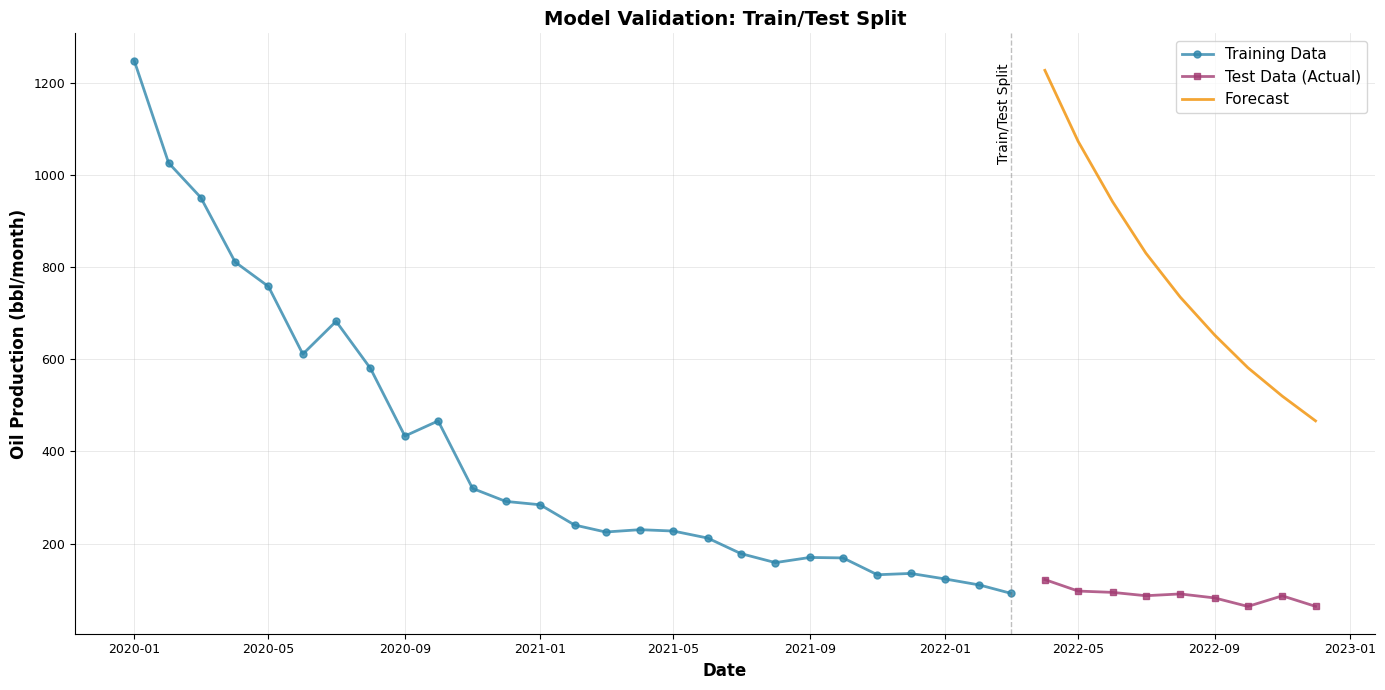

In [12]:
# Visualize train/test split and forecast
fig, ax = plt.subplots(figsize=(14, 7))

# Training data
ax.plot(train_data.index, train_data.values, 'o-', linewidth=2, markersize=5,
        label='Training Data', color='#2E86AB', alpha=0.8)

# Test data
ax.plot(test_data.index, test_data.values, 's-', linewidth=2, markersize=5,
        label='Test Data (Actual)', color='#A23B72', alpha=0.8)

# Forecast
ax.plot(test_data.index, test_forecast, '-', linewidth=2,
        label='Forecast', color='#F18F01', alpha=0.8)

# Add vertical line at split point
ax.axvline(train_data.index[-1], color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax.text(train_data.index[-1], ax.get_ylim()[1] * 0.95, 'Train/Test Split', 
        rotation=90, ha='right', va='top', fontsize=10)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Oil Production (bbl/month)', fontsize=12, fontweight='bold')
ax.set_title('Model Validation: Train/Test Split', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Summary and Best Practices {#summary}

### Key Takeaways

1. **Data Preparation**: Always ensure your data is in the correct format (pandas Series with DatetimeIndex)
2. **Model Selection**: Compare multiple models and select based on fit quality (R², RMSE)
3. **Validation**: Use train/test splits to validate model performance
4. **Visualization**: Always visualize fits and forecasts to catch issues
5. **Reserve Estimation**: Use appropriate economic limits for EUR calculations

### Next Steps

- Explore economic evaluation (see `02_economic_evaluation.ipynb`)
- Learn about multi-phase forecasting (see `05_multiphase_forecasting.ipynb`)
- Try advanced ML models (see `07_ml_forecasting.ipynb`)
- Learn about physics-informed DCA (see `09_physics_informed_dca.ipynb`)